# Neural Backed Decision Trees Demo

I will be using NBDT to run a classification task on the dataset CIFAR-10 Object Recognition in Images dataset. The dataset consists of 60,000 images of 10 different classes: 

> 1. Plane
> 2. Car
> 3. Bird
> 4. Cat
> 5. Deer
> 6. Dog
> 7. Frog
> 8. Horse
> 9. Ship
> 10. Truck

Each image is either of a type of animal or vechicle belonging to the above classes. 

Read more about the data here: https://www.kaggle.com/competitions/cifar-10/data.

In [ ]:
%pip install nbdt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 119 kB 11.1 MB/s 
     |████████████████████████████████| 532 kB 22.8 MB/s 
  Created wheel for nbdt: filename=nbdt-0.0.4-py3-none-any.whl size=132338 sha256=e797d0bbab9472c54ea2b41fa06219e8d126109c542fd9587f77fdad9a4af16a
  Stored in directory: /root/.cache/pip/wheels/1f/3f/10/02973cef706abb89dd9ed79337887e7eeddd4ebbb36f6cfa2b
Successfully built nbdt


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

### Exploring the Data

First I will import the data and examine its structure so I am familar with it. I will create batch sizes of 4 and transfrom the images to normalize them all to the same shape.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Next I can examine what an example batch will look like with the images and labels.

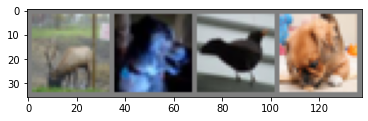

deer  dog   bird  dog  


In [ ]:

# Show some images to verify data successfully loaded
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Creating NBDT Model

Next I will import the libraries need for NBDT and create model for the demo and testing. For convenience, I can use a pretained WideResNet model for computer vision from the pytorch torchvision.models library.  

In [ ]:
from nbdt.models import ResNet18, wrn28_10_cifar10, wrn28_10_cifar100, wrn28_10
from nbdt.utils import DATASET_TO_CLASSES, load_image_from_path, maybe_install_wordnet
from IPython.display import display
from nbdt.model import SoftNBDT

not enough values to unpack (expected 2, got 0)


In [ ]:

model = wrn28_10_cifar10()
model = SoftNBDT(
  pretrained=True,
  hierarchy='wordnet',
  dataset='CIFAR10',
  arch='wrn28_10_cifar10',
  model=model)

Downloading: "https://github.com/alvinwan/neural-backed-decision-trees/releases/download/0.0.1/ckpt-CIFAR10-wrn28_10_cifar10-wordnet-SoftTreeSupLoss.pth" to /root/.cache/torch/checkpoints/ckpt-CIFAR10-wrn28_10_cifar10-wordnet-SoftTreeSupLoss.pth


  0%|          | 0.00/139M [00:00<?, ?B/s]

### Testing Model

In the above I can specify hierarchy='wordnet' to tell the NBDT library I want to build decision tree hierachy and assign labels to intermediate nodes using WordNet. 

In [ ]:
image_urls = {
    'cat': 'https://images.pexels.com/photos/126407/pexels-photo-126407.jpeg?auto=compress&cs=tinysrgb&dpr=2&w=300',
    'bear': 'https://images.pexels.com/photos/158109/kodiak-brown-bear-adult-portrait-wildlife-158109.jpeg?auto=compress&cs=tinysrgb&dpr=2&w=300',
    'dog': 'https://images.pexels.com/photos/1490908/pexels-photo-1490908.jpeg?auto=compress&cs=tinysrgb&dpr=2&w=300'
}


#### Generalizing for unseen classes
Consider the case where I interoduce an image that is not part of the training classes but similar. I would expect the model to pick the class that is as visually similar as possible to the new unknown class. For example, if I introduce an image of a bear that is a unknown class to the model I should expect it to try and classify it as an animal and not vehicle and the closest looking animal in general to a bear. I load 3 test images, 2 known and 1 unknown class, to test hypothesis below.

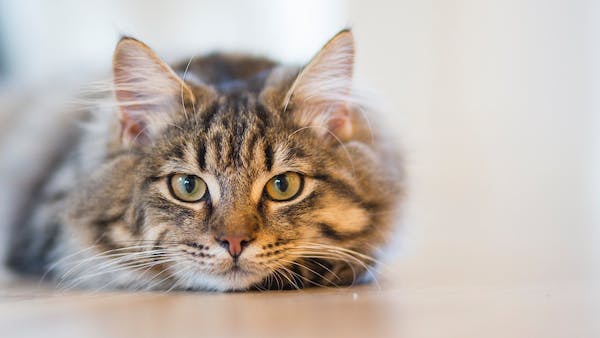

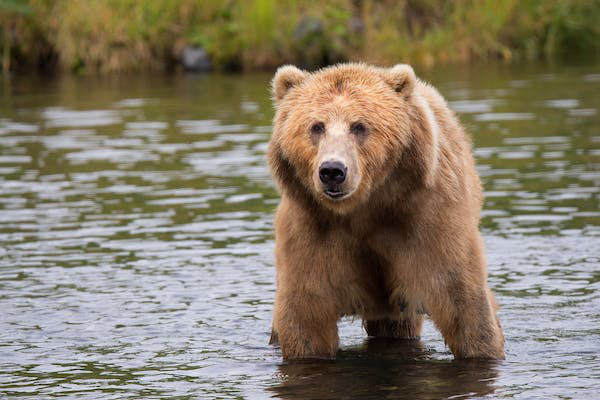

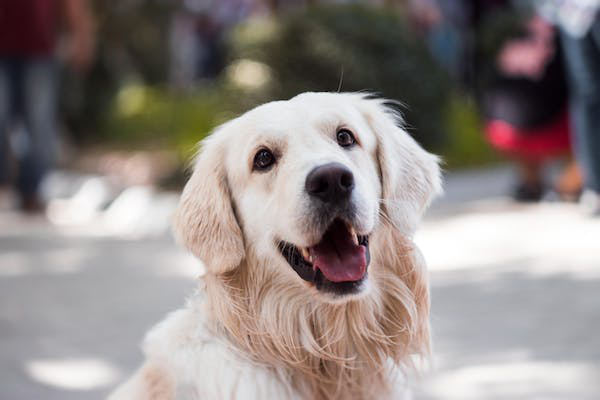

In [ ]:
# show images
images = []
for i in image_urls:
  im = load_image_from_path(image_urls[i])
  images.append(im)
  display(im)

In [ ]:
from torchvision import transforms

transforms = transforms.Compose([
  transforms.Resize(32),
  transforms.CenterCrop(32),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

t_images = []

for i in images:
  x = transforms(i)[None]
  t_images.append(x)

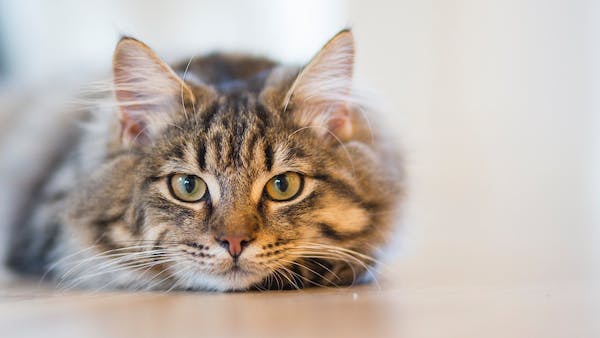

The predicted class is: cat
The model is 99.8517632484436% certain this class is correct


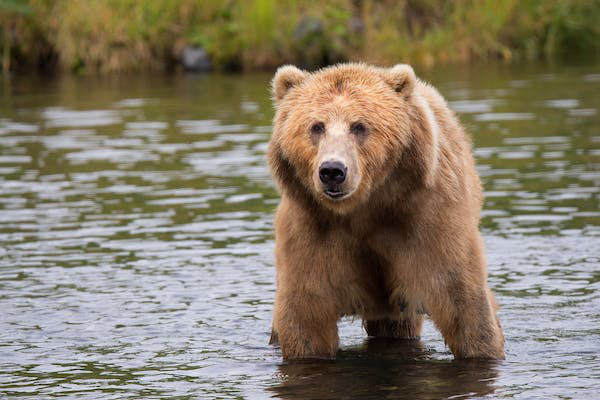

The predicted class is: dog
The model is 99.90288615226746% certain this class is correct


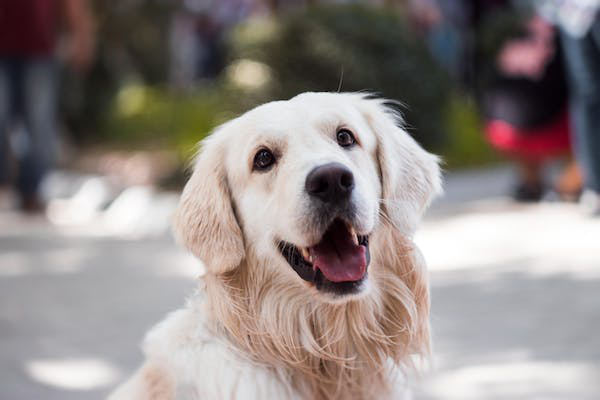

The predicted class is: dog
The model is 99.92213249206543% certain this class is correct


In [ ]:
# run inference for each
for idx, im in enumerate(t_images):
  outputs = model(im)  # to get intermediate decisions, use `model.forward_with_decisions(x)` and add `hierarchy='wordnet' to SoftNBDT
  _, predicted = outputs.max(1)
  cls = DATASET_TO_CLASSES['CIFAR10'][predicted[0]]
  display(images[idx])
  print(f'The predicted class is: {cls}')
  print(f'The model is {outputs.max(1).values.detach().numpy()[0] * 100}% certain this class is correct')

The Results support hypothesis and the bear image is classified as a dog which is the most similar visually to the image of the bear. The advantage of the NBDT is that for the unknown class I can accurately get a higher level generalization of what the image is of. For this example, the bear will be classified as and animal and a carnivore before being classified as a dog and I can use this information to get higher order classifications of unseen classes and see the models classification logic from top down. an example of the output decision tree for this case is somthing like the below:
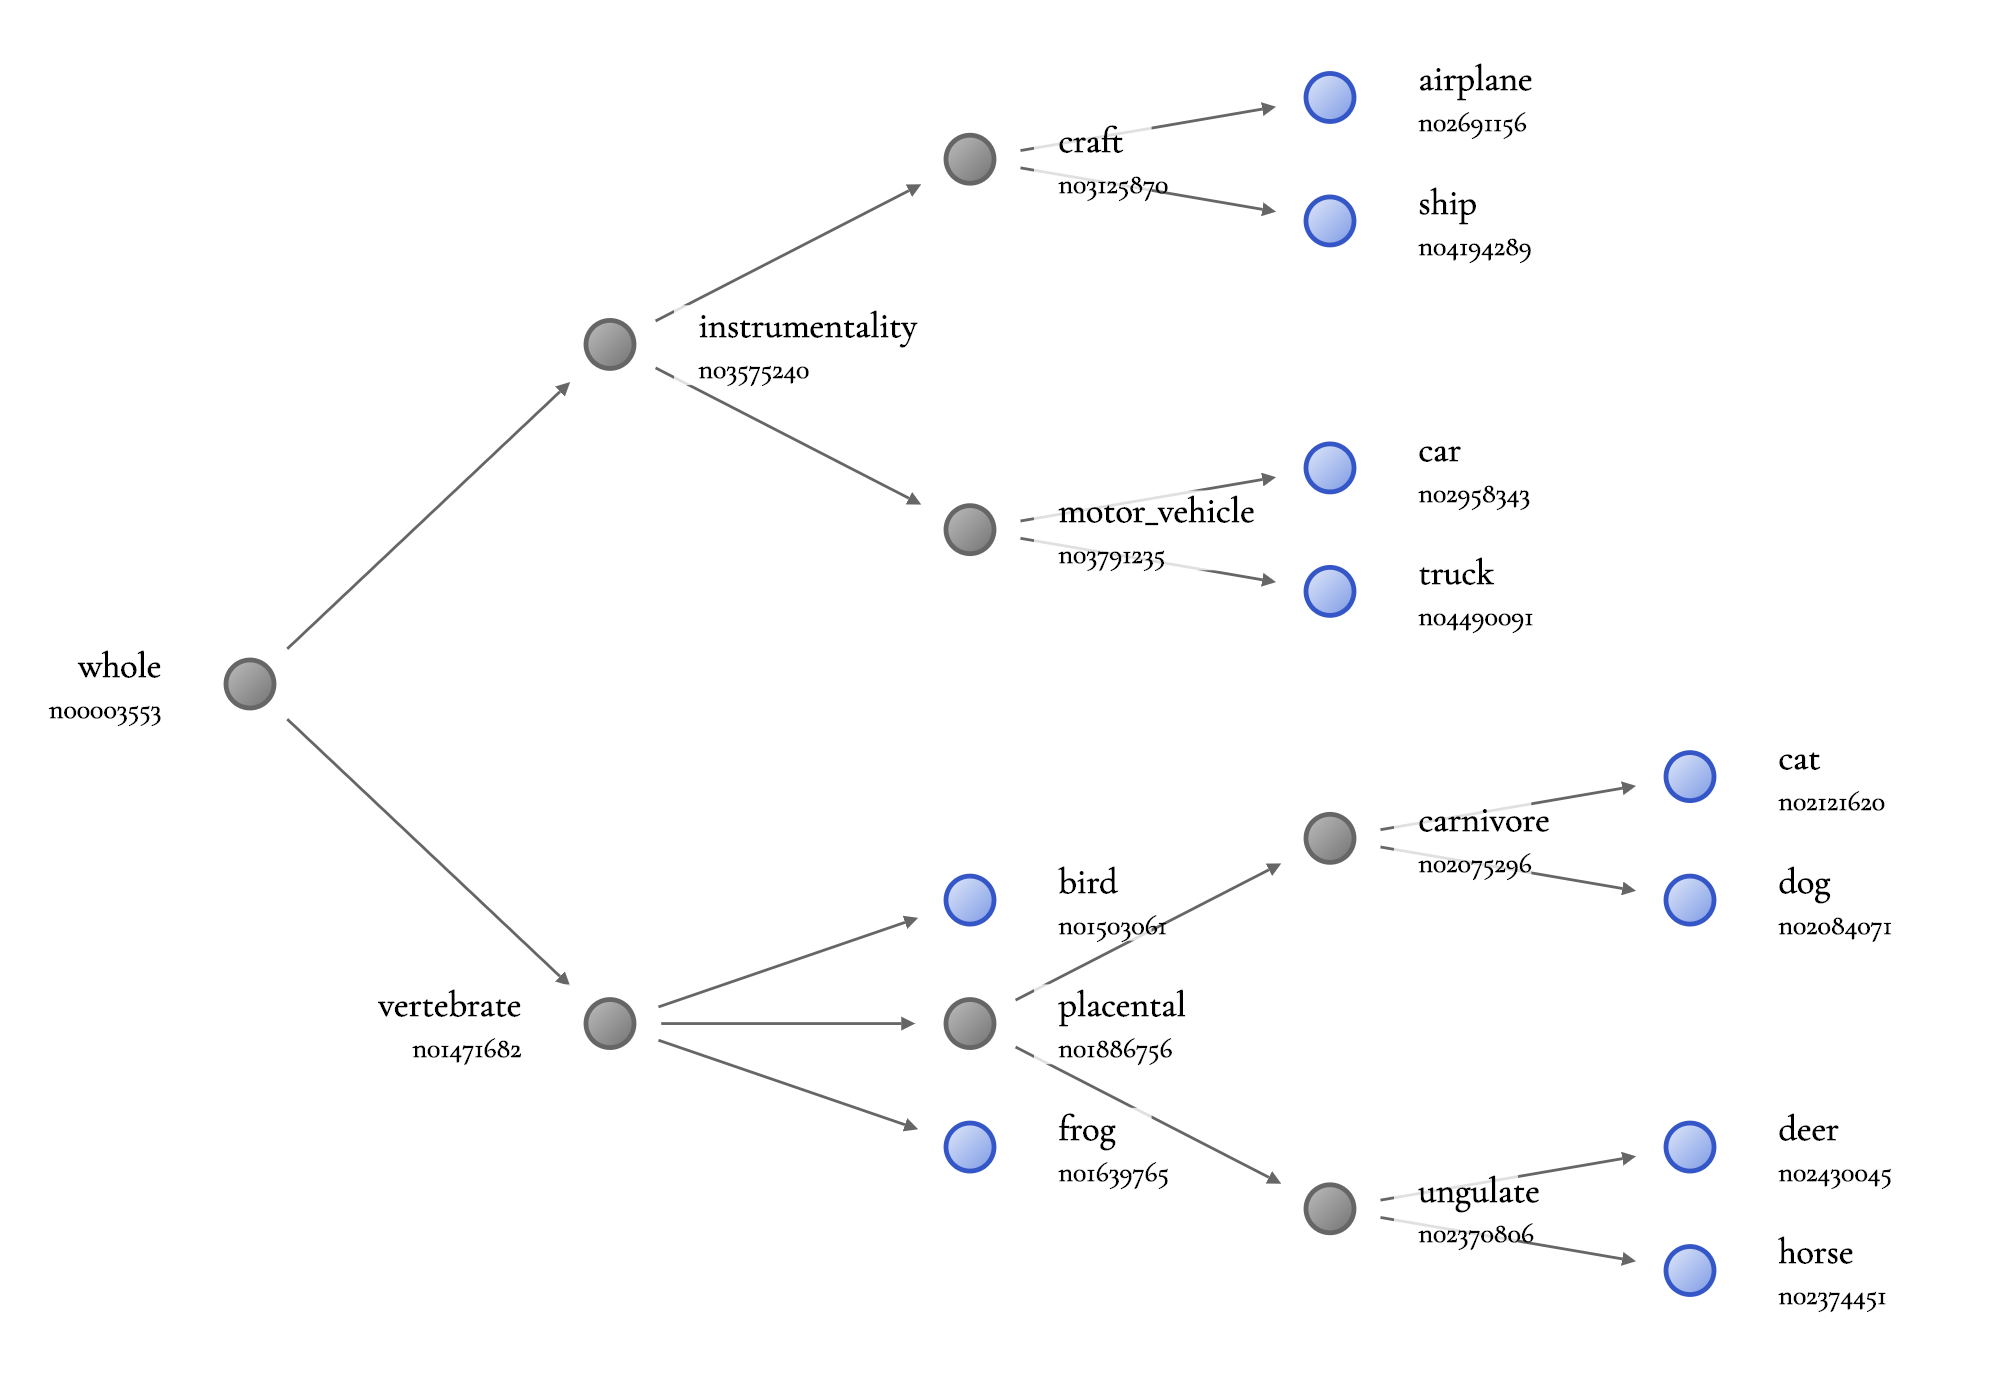

#### Total Classification Performance of Model

Lastly, I can test to see the total classification accuracy of model to test and ensure that NBDT layer did not result in any significant decrease of accuracy. 

In [ ]:
# Test on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


SoftNBDT(
  (model): CIFARWRN(
    (features): Sequential(
      (init_block): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (stage1): Sequential(
        (unit1): PreResUnit(
          (body): PreResBlock(
            (conv1): PreConvBlock(
              (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activ): ReLU(inplace=True)
              (conv): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            )
            (conv2): PreConvBlock(
              (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activ): ReLU(inplace=True)
              (conv): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            )
          )
          (identity_conv): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (unit2): PreResUnit(
          (body): PreResBlock

In [ ]:
# See Test Results for whole Network
correct = 0
total = 0
# since we're not training, I don't need to calculate the gradients for outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


Model is preforming well with 90% accuracy so intrepretability of last decision tree layer has not decreased the accuracy. I can inspect for each class the accuracy to see if some more visually distinct classes preform better than others. 

In [ ]:
# Test Accuracy per class to see what the model is struggling with
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        label = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 90.6 %
Accuracy for class: car   is 91.8 %
Accuracy for class: bird  is 90.3 %
Accuracy for class: cat   is 90.5 %
Accuracy for class: deer  is 94.0 %
Accuracy for class: dog   is 80.0 %
Accuracy for class: frog  is 94.0 %
Accuracy for class: horse is 90.8 %
Accuracy for class: ship  is 95.6 %
Accuracy for class: truck is 91.9 %


The results confirm that more visually distinct classes such as ship have very high accuracy where other classes like dog that have many different species that can look very different have the lowest accuracy as I expected.  